<a href="https://colab.research.google.com/github/yijinong/zero-DCE/blob/main/test_zeroDCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/lol_dataset.zip


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400

def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image

def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [5]:
import os.path
from os import path

if path.exists('/content/lol_dataset/denoise_our485') == False:
  os.mkdir('/content/lol_dataset/denoise_our485')

os.chdir('/content/lol_dataset/denoise_our485')

In [6]:
import cv2 as cv
from glob import glob
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir

path = "/content/lol_dataset/our485/low/"
files = listdir(path)
# declare valid filtypes
valid_image_extensions = [".jpg", ".jpeg", ".png", ".tif", ".tiff"]
new_folder = "/content/lol_dataset/denoise_our485/"


for name in files:
  
            # check if it is a valid filetype
  filename, file_extension = os.path.splitext(name)
  #print(filename)
  if file_extension in valid_image_extensions:
    # create a folder for this image
    new_path = new_folder+filename
    print(new_path)
    if not os.path.exists(path):
      os.makedirs(path)
  
  # load image in grayscale
  img = cv.imread(path+name, 1)
  
  if img is None:
        print("Image is empty!!")
        pass
  else:
        #print("Image is not empty!!")
        #print("Shape of image ", img.shape)
        converted_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        dst = cv.fastNlMeansDenoisingColored(converted_img,None,10,10,7,21)

        #plt.subplot(121), plt.imshow(img)
        #plt.subplot(122), plt.imshow(dst)
        #plt.show()
        converted_dst = cv.cvtColor(dst, cv.COLOR_RGB2BGR)
        cv.imwrite(new_path+".png", converted_dst)
print('done')
                  



Populating the interactive namespace from numpy and matplotlib
/content/lol_dataset/denoise_our485/663


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


/content/lol_dataset/denoise_our485/676
/content/lol_dataset/denoise_our485/220
/content/lol_dataset/denoise_our485/703
/content/lol_dataset/denoise_our485/700
/content/lol_dataset/denoise_our485/528
/content/lol_dataset/denoise_our485/10
/content/lol_dataset/denoise_our485/529
/content/lol_dataset/denoise_our485/776
/content/lol_dataset/denoise_our485/51
/content/lol_dataset/denoise_our485/553
/content/lol_dataset/denoise_our485/649
/content/lol_dataset/denoise_our485/543
/content/lol_dataset/denoise_our485/114
/content/lol_dataset/denoise_our485/222
/content/lol_dataset/denoise_our485/506
/content/lol_dataset/denoise_our485/701
/content/lol_dataset/denoise_our485/540
/content/lol_dataset/denoise_our485/535
/content/lol_dataset/denoise_our485/517
/content/lol_dataset/denoise_our485/682
/content/lol_dataset/denoise_our485/468
/content/lol_dataset/denoise_our485/95
/content/lol_dataset/denoise_our485/737
/content/lol_dataset/denoise_our485/259
/content/lol_dataset/denoise_our485/512
/co

In [7]:
train_low_light_images = sorted(glob("/content/lol_dataset/denoise_our485/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("/content/lol_dataset/denoise_our485/*"))[MAX_TRAIN_IMAGES:]

train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


In [8]:
def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)

In [9]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))

In [10]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

In [11]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

In [12]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down

In [13]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )

Epoch 1/100
25/25 [==============================] - 21s 314ms/step - total_loss: 4.8440 - illumination_smoothness_loss: 1.8999 - spatial_constancy_loss: 8.0575e-05 - color_constancy_loss: 0.0036 - exposure_loss: 2.9405 - val_total_loss: 4.5177 - val_illumination_smoothness_loss: 1.4996 - val_spatial_constancy_loss: 5.2812e-05 - val_color_constancy_loss: 4.2838e-04 - val_exposure_loss: 3.0177
Epoch 2/100
25/25 [==============================] - 7s 287ms/step - total_loss: 4.0697 - illumination_smoothness_loss: 1.1304 - spatial_constancy_loss: 7.1754e-05 - color_constancy_loss: 0.0029 - exposure_loss: 2.9363 - val_total_loss: 3.9062 - val_illumination_smoothness_loss: 0.8945 - val_spatial_constancy_loss: 6.2864e-05 - val_color_constancy_loss: 3.6168e-04 - val_exposure_loss: 3.0112
Epoch 3/100
25/25 [==============================] - 7s 290ms/step - total_loss: 3.6915 - illumination_smoothness_loss: 0.7602 - spatial_constancy_loss: 8.3018e-05 - color_constancy_loss: 0.0027 - exposure_los

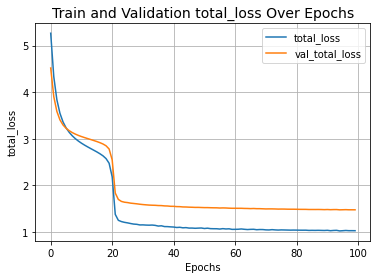

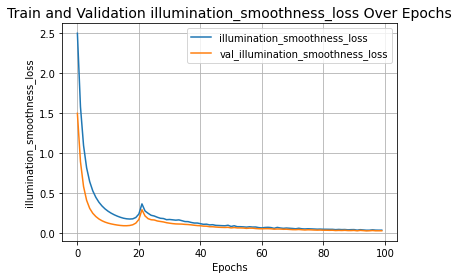

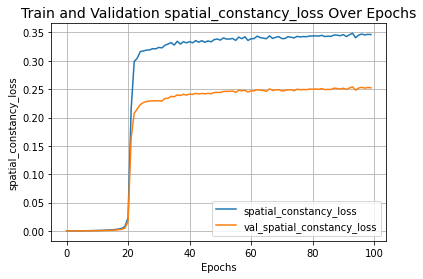

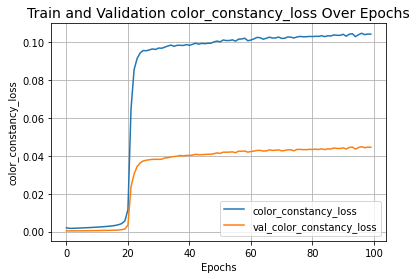

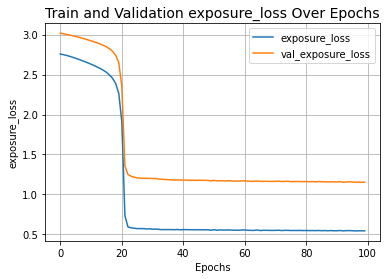

In [14]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=100)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

In [15]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

In [16]:
for val_image_file in test_low_light_images:
    original_image = Image.open(val_image_file)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "Enhanced"],
        (20, 12),
    )

NameError: ignored